GW170817_GalacticNS.ipynb -- reweight GW170817 posterior to Galactic NS population

In [1]:
# import packages

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import h5py
import requests as rq
import random
random.seed(2022)

In [2]:
# import sodapop

! git clone https://github.com/landryp/sodapop.git # only need to run this once
import sys
import os
sys.path.insert(0,os.getcwd()+'/sodapop')
import sodapop.priors as prior
import sodapop.populations as pop

Cloning into 'sodapop'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 759 (delta 52), reused 48 (delta 34), pack-reused 683
Receiving objects: 100% (759/759), 2.76 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (414/414), done.


In [3]:
# get gw170817 posterior samples

public_dcc_url= 'https://dcc.ligo.org/public/0150/P1800061/011/'
!curl -O {public_dcc_url}"high_spin_PhenomPNRT_posterior_samples.dat.gz"

data = pd.read_table('high_spin_PhenomPNRT_posterior_samples.dat.gz', delim_whitespace=True)
pnames = data.columns.values
print(pnames)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  971k  100  971k    0     0   998k      0 --:--:-- --:--:-- --:--:--  997k
['costheta_jn' 'luminosity_distance_Mpc' 'm1_detector_frame_Msun'
 'm2_detector_frame_Msun' 'lambda1' 'lambda2' 'spin1' 'spin2' 'costilt1'
 'costilt2']


In [4]:
# convert detector frame masses to source frame in gw170817 samples -- note that the paper actually fixed z = 0.0099

data['m1'] = data.apply(lambda row : row['m1_detector_frame_Msun'] / (1+0.0099) , axis = 1)
data['m2'] = data.apply(lambda row : row['m2_detector_frame_Msun'] / (1+0.0099) , axis = 1)

In [5]:
# define transformed observables

def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

data['mchirp'] = data.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
data['q']= data.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
data['chi_eff']= data.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
data['lambdatilde'] = data.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

In [6]:
# define new population-informed prior and reweight gw170817 posterior samples to it

old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det_quad_dL') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('bimodcut_m1m2_dns_spins_common_Lambda1Lambda2') # function of m1, m2, chi1, chi2, cost1, cost2, Lambda1, Lambda2, population parameters
pop_params = [1.34, 0.07, 1.80, 0.21, 0.65, 0.9, 2.12, -1., 0., 0.4, -1., 0., 0.05, 0., 5000.] # maximum a posteriori population model from arXiv:1709.07889

#data = data.truncate(after=1000)

# weight samples based on galactic mass prior
data['massweight']  = data.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['costilt1'],row['costilt2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data['massweight']=[d[0] for d in data['massweight']/data['massweight'].sum() * data['massweight'].size]

In [7]:
# store the unweighted and reweighted samples in a dataframe

data0 = data.copy()
data0['massweight'] = np.ones(len(data0['massweight']))

data['prior'] = 'Galactic'
data0['prior'] = 'LVC'

df = pd.concat([data, data0]).reset_index()

In [8]:
# now let's add some uncertainty to the population model by loading many realizations of the population-informed prior

pop_posterior_path = 'https://github.com/farr/AlsingNSMassReplication/raw/master/ar.nc' # get bimodal population parameter posterior samples from arXiv:2005.00032
pop_posterior_file = rq.get(pop_posterior_path,allow_redirects=True)
with open('ar.nc','wb') as outfile:
		outfile.write(pop_posterior_file.content)
pop_posterior = h5py.File('ar.nc','r')

mu1s = list(np.array(pop_posterior['posterior']['mus'][:,:,0]).flatten())
mu2s = list(np.array(pop_posterior['posterior']['mus'][:,:,1]).flatten())
sigma1s = list(np.array(pop_posterior['posterior']['sigmas'][:,:,0]).flatten())
sigma2s = list(np.array(pop_posterior['posterior']['sigmas'][:,:,1]).flatten())
mmaxs = list(np.array(pop_posterior['posterior']['mmax'][:,:]).flatten())
mmins = list(np.full(len(mmaxs),0.))
ws = list(np.array(pop_posterior['posterior']['As'][:,:,0]).flatten())

In [9]:
# reweight to each realization of the population-informed prior, and marginalize

num_pops = 50

ii = 0
for pop_params in zip(mu1s,sigma1s,mu2s,sigma2s,ws,mmins,mmaxs):

  pop_params = list(pop_params) + [-1., 0., 0.4, -1., 0., 0.05, 0., 5000.]

  pop_data = data0.sample(5000)

  pop_data['massweight'] = pop_data.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['costilt1'],row['costilt2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)

  pop_data['massweight']=[d[0] for d in pop_data['massweight']/pop_data['massweight'].sum() * pop_data['massweight'].size]

  pop_data['prior'] = 'Galactic {0}'.format(ii)
  if ii == 0: popmarg_data = pop_data
  else: popmarg_data = popmarg_data.append(pop_data)

  ii += 1
  if ii >= num_pops: break

In [10]:
# store the population-marginalized samples in the dataframe with the others

marg_df = pd.concat([data,data0,popmarg_data]).reset_index()

In [11]:
# reflect kde

reflected_df = data.truncate(after=1).copy()
reflected_idx = 0

for idx in list(marg_df.index.values):

	q = marg_df.at[idx,'q']
	Lt = marg_df.at[idx,'lambdatilde']
	
	if q > 0.95:
		reflected_df.loc[reflected_idx] = marg_df.loc[idx]
		reflected_df.loc[reflected_idx].at['q'] = 1. + np.abs(1.-q)
		reflected_idx = reflected_idx + 1
		
	if Lt < 5.:
		reflected_df.loc[reflected_idx] = marg_df.loc[idx]
		reflected_df.loc[reflected_idx].at['lambdatilde'] = -np.abs(Lt)
		reflected_idx = reflected_idx + 1

reflected_df=reflected_df.drop(reflected_df.index[0])
marg_df = pd.concat([marg_df.reset_index(drop=True),reflected_df.reset_index(drop=True)],ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(loc, value)


In [12]:
# specify some global plot settings

sns.set_palette([sns.color_palette("Paired")[1],sns.color_palette("Paired")[3],'k',sns.color_palette("Paired")[8]])
palette = {"Galactic (prior)": 'gray', 'LVC (prior)': sns.color_palette()[1], 'Galactic': sns.color_palette()[2], 'LVC': sns.color_palette()[1]}
for jj in range(ii): palette['Galactic {0}'.format(jj)] = sns.color_palette()[0]

replacements = {'m1': r'$m_1 \,[M_\odot]$', 'm2': r'$m_2 \,[M_\odot]$', 'spin1': r'$\chi_1$', 'spin2': r'$\chi_2$', 'lambda1': r'$\Lambda_1$', 'lambda2': r'$\Lambda_2$', 'mchirp': r'$\mathcal{M} \,[M_\odot]$', 'q': r'$q$', 'chi_eff': r'$\chi_\mathrm{eff}$', 'lambdatilde': r'$\tilde{\Lambda}$'}
limits = {'m1': (1.2,2.0), 'm2': (0.8,1.6), 'spin1': (0.,1.), 'spin2': (0.,1.), 'lambda1': (0.,2500.), 'lambda2': (0.,2500.), 'mchirp': (1.1,1.2), 'q': (0.3,1.), 'chi_eff': (-0.05,0.2), 'lambdatilde': (0.,2500.)}

lower_priors = ["Galactic (prior)"]
diag_priors = ['LVC (prior)','Galactic (prior)']
posts = ['LVC','Galactic']
traces = ["Galactic {0}".format(jj) for jj in range(ii)]

handles = {}
for key in palette.keys():
  if '(prior)' in key: handles[key] = mlines.Line2D([], [], color=palette[key], ls=':', label=key)
  elif key == 'Galactic': handles[key] = (mpatches.Patch(facecolor=palette['Galactic 0'], edgecolor=None, alpha=0.2, label=key), mlines.Line2D([], [], color=palette['Galactic'], label=key))
  else: handles[key] = mlines.Line2D([], [], color=palette[key], label=key)

In [18]:
def fancy_corner(df,vars,hue_col='prior',wt_col='massweight',lower_priors=lower_priors,diag_priors=diag_priors,prior_alpha=0.5,posts=posts,post_levels=[0.1,0.5],traces=traces,trace_levels=[0.1],trace_alpha=0.1,handles=handles,palette=palette,replacements=replacements,limits=limits,height=2.5):

  fig = sns.PairGrid(df, vars=vars, corner=True, diag_sharey=False, height=height)

  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=traces, palette=palette, fill=False, alpha=trace_alpha, common_norm=False, weights=df[wt_col])
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=posts, palette=palette, fill=False, common_norm=False, weights=df[wt_col])
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=traces, palette=palette, levels=trace_levels, alpha=trace_alpha, weights=df[wt_col])
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=posts, palette=palette, levels=post_levels, weights=df[wt_col])
  fig.add_legend(label_order=posts,legend_data=handles,fontsize=16)

  for i in range(len(vars)):
    for j in range(i+1):
        xlabel = vars[j]
        ylabel = vars[i]
        if xlabel in replacements.keys():
            fig.axes[i][j].set_xlabel(replacements[xlabel],fontsize=16)
            fig.axes[i][j].set_xlim(*limits[xlabel])
        if ylabel in replacements.keys():
            fig.axes[i][j].set_ylabel(replacements[ylabel],fontsize=16)
            fig.axes[i][j].set_ylim(*limits[ylabel])

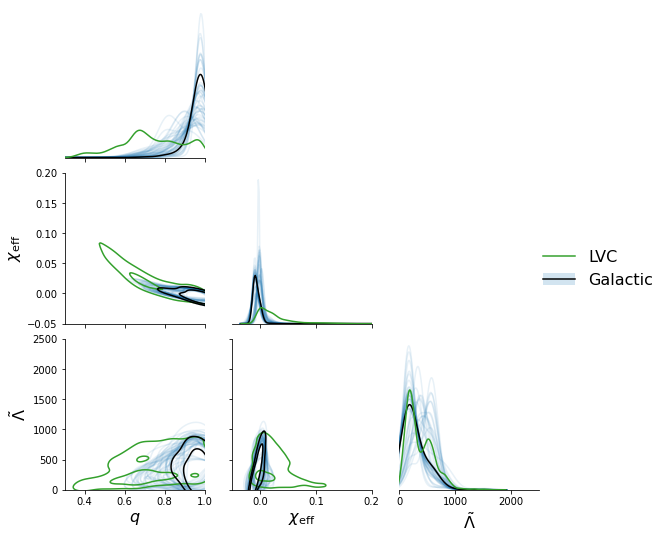

In [14]:
# make a corner plot of the transformed variables

fancy_corner(marg_df,["q","chi_eff",'lambdatilde'])

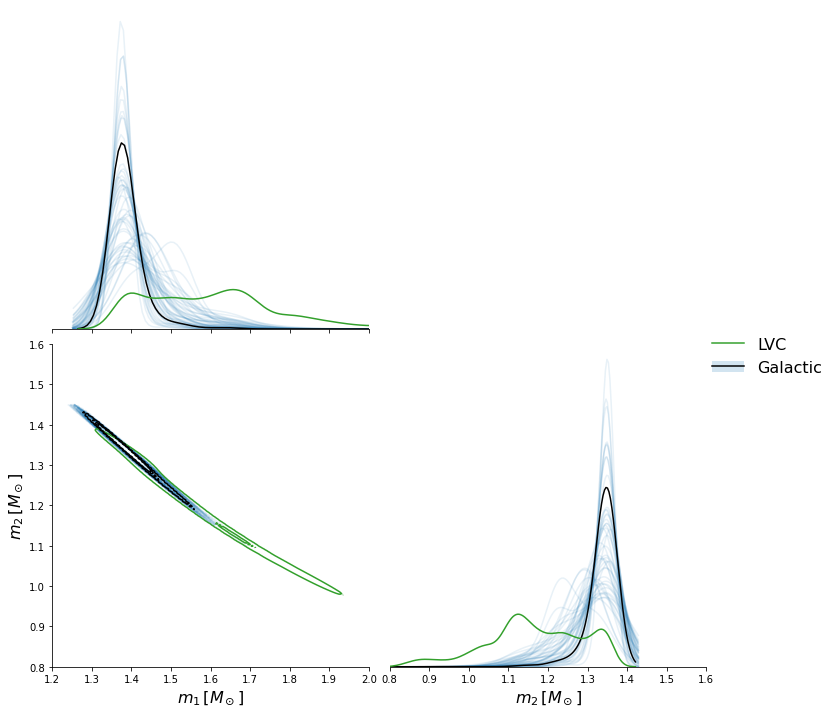

In [19]:
# make a corner plot of the component masses

fancy_corner(marg_df,["m1","m2"],height=5.)

In [17]:
# calculate medians and 90% credible intervals

def kde_quantile(data,quant,bounds,wts=None,stp=0.01):

  p_of_data = scipy.stats.gaussian_kde(data,weights=wts)
  data_grid = np.arange(bounds[0],bounds[1],stp)
  num_stp = len(data_grid)

  prob = 0.
  i = 0

  if quant > 0.5:
    
    quant = 1.-quant
    while prob < quant:

      i = i+1
      prob = np.trapz(p_of_data(data_grid[num_stp-i:]),data_grid[num_stp-i:])

    return np.around(data_grid[num_stp-i],-int(np.log10(stp)))

  else:
  
    while prob < quant:

      i = i+1
      prob = np.trapz(p_of_data(data_grid[:i]),data_grid[:i])

    return np.around(data_grid[i-1],-int(np.log10(stp)))

def print_med_90cl(var,data,bounds,wts=None,stp=0.01):

  num_dec = -int(np.log10(stp))
  if num_dec < 0: num_dec = 0

  return print('${0} = {1:.{prec}f}_{{-{2:.{prec}f}}}^{{+{3:.{prec}f}}}$'.format(var,kde_quantile(data,0.5,bounds,wts,stp),np.around(kde_quantile(data,0.5,bounds,wts,stp)-kde_quantile(data,0.05,bounds,wts,stp),num_dec),np.around(kde_quantile(data,0.95,bounds,wts,stp)-kde_quantile(data,0.5,bounds,wts,stp),num_dec), prec=num_dec))

print_med_90cl('m1',marg_df[marg_df['prior']=='LVC']['m1'],(0.5,2.5))
print_med_90cl('m1',marg_df[marg_df['prior']=='Galactic']['m1'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Galactic']['massweight'])

print_med_90cl('m2',marg_df[marg_df['prior']=='LVC']['m2'],(0.5,2.5))
print_med_90cl('m2',marg_df[marg_df['prior']=='Galactic']['m2'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Galactic']['massweight'])

print_med_90cl('q',marg_df[marg_df['prior']=='LVC']['q'],(0.,1.))
print_med_90cl('q',marg_df[marg_df['prior']=='Galactic']['q'],(0.,1.),wts=marg_df[marg_df['prior']=='Galactic']['massweight'])

print_med_90cl('\\chi_\\rm{eff}',marg_df[marg_df['prior']=='LVC']['chi_eff'],(-1.,1.))
print_med_90cl('\\chi_\\rm{eff}',marg_df[marg_df['prior']=='Galactic']['chi_eff'],(-1.,1.),wts=marg_df[marg_df['prior']=='Galactic']['massweight'])

print_med_90cl('\\tilde{\\Lambda}',marg_df[marg_df['prior']=='LVC']['lambdatilde'],(0.,2000.),stp=10.)
print_med_90cl('\\tilde{\\Lambda}',marg_df[marg_df['prior']=='Galactic']['lambdatilde'],(0.,2000.),wts=marg_df[marg_df['prior']=='Galactic']['massweight'],stp=10.)

$m1 = 1.61_{-0.24}^{+0.44}$
$m1 = 1.39_{-0.06}^{+0.07}$
$m2 = 1.17_{-0.23}^{+0.18}$
$m2 = 1.35_{-0.08}^{+0.04}$
$q = 0.73_{-0.27}^{+0.23}$
$q = 0.98_{-0.11}^{+0.00}$
$\chi_\rm{eff} = 0.02_{-0.02}^{+0.07}$
$\chi_\rm{eff} = 0.00_{-0.01}^{+0.00}$
$\tilde{\Lambda} = 310_{-230}^{+510}$
$\tilde{\Lambda} = 290_{-240}^{+410}$
